In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd=tfp.distributions
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle
tf.compat.v1.disable_eager_execution()
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Class dense

In [2]:
class Denseab(object):
    def __init__(self,name,M1,M2,apply_batch_norm,f=tf.nn.relu):
        
        self.W=tf.get_variable("W%s" %name,shape=(M1,M2),initializer=tf.random_normal_initializer(stddev=2/np.sqrt(M1)),dtype=tf.float32)
        #tf.Variable(tf.random_normal((M1,M2))*2/np.sqrt(M1))
        self.b=tf.get_variable("b%s" %name,shape=(M2,),initializer=tf.zeros_initializer(),dtype=tf.float32)
        #tf.Variable(tf.zeros(M2),dtype=tf.float32)
        self.f=f
        self.bm=apply_batch_norm
    
    def forward(self,X):
            
        sal=tf.matmul(X,self.W)+self.b
    
        if self.bm:
            sal=tf.layers.batch_normalization(sal)
            #tf.keras.layers.BatchNormalization(trainable=True)(sal)
            
        return(self.f(sal))  

# Class Conv

In [3]:
class ConvLayer:
    def __init__(self,name,tam,filtros,tam_filtros,stride,pad,apply_batch_norm,f=tf.nn.relu):
        """
        Input:
              tam.-int número de canales o colores en imágenes ex: RGB son 3
              filtros.- int número de filtros a usar
              tam_filtros.- int tamaño de los filtros si tam=n fitro es de n x n
              stride.- int número de strides para recorrer
              pad.-string padding
              apply_bm...- bool si se usa batch normalization
              f.-object función de activación
              
          Out:
              self.W.- array de tam_fitros x tam_filtros  x tam x filtros son los pesos de los filtros definidos
              self.b.- array de biases de dimensión filtros so los biases que se usan
        
        """
        self.W=tf.get_variable("W%s" %name,shape=(tam_filtros,tam_filtros,tam,filtros),initializer=tf.random_normal_initializer(stddev=(2/np.sqrt(filtros))),dtype=tf.float32)
        #tf.Variable(tf.random_normal((tam_filtros,tam_filtros,tam,filtros))*2/np.sqrt(filtros))
        self.b=tf.get_variable("b%s" %name,shape=(filtros,),initializer=tf.zeros_initializer(),dtype=tf.float32)
        #tf.Variable((tf.zeros(filtros)),dtype=tf.float32)

        self.filtros=filtros
        self.tam_filtros=tam_filtros
        self.stride=stride
        self.pad=pad
        self.f=f
        self.bm=apply_batch_norm
            
    def forward(self,X):
        """
        Input:
              X.-array input 
          Out:
              self.f(sal)- array de f(filtros) convolucionados con X
        
        """        
        sal=tf.nn.conv2d(X,filter=self.W,strides=self.stride,padding=self.pad)
        sal=sal+self.b
        if self.bm:
            return(self.f(tf.layers.batch_normalization(sal)))
        else:
            return(self.f(sal))
    

# Class ConvT

In [4]:
class ConvLayerTranspose:
    def __init__(self,name,out_shape,tam,filtros,tam_filtros,stride,pad,apply_batch_norm,f=tf.nn.relu):
        """
        Input:
              out_shape.-array tamaño deseado de salida normalmente es (None,2*H,2*W,filtros/2)
              tam.-int número de canales o colores en imágenes ex: RGB son 3
              filtros.- int número de filtros a usar
              tam_filtros.- int tamaño de los filtros si tam=n fitro es de n x n
              stride.- int número de strides para recorrer
              pad.-string padding
              apply_bm...- bool si se usa batch normalization
              f.-object función de activación
              
          Out:
              self.W.- array de tam_fitros x tam_filtros  x filtros x tam (al revés que conv) son los pesos de los filtros definidos
              self.b.- array de biases de dimensión filtros so los biases que se usan
        
        """
        self.W=tf.get_variable("W%s" %name,shape=(tam_filtros,tam_filtros,filtros,tam),initializer=tf.random_normal_initializer(stddev=(2/np.sqrt(filtros))),dtype=tf.float32)
        #tf.Variable(tf.random_normal((tam_filtros,tam_filtros,filtros,tam))*2/np.sqrt(filtros))
        self.b=tf.get_variable("b%s" %name,shape=(filtros,),initializer=tf.zeros_initializer(),dtype=tf.float32)
        #tf.Variable((tf.zeros(filtros)),dtype=tf.float32)

        self.out_shape=out_shape
        self.filtros=filtros
        self.tam_filtros=tam_filtros
        self.stride=stride
        self.pad=pad
        self.f=f
        self.bm=apply_batch_norm
            
    def forward(self,X):
        """
        Input:
              X.-array input 
          Out:
              self.f(sal)- array de f(filtros) convolucionados con X
        
        """        
        sal=tf.nn.conv2d_transpose(value=X,filter=self.W,output_shape=self.out_shape,strides=self.stride,padding=self.pad)
        
        sal=sal+self.b
        #print(self.f(tf.keras.layers.BatchNormalization()(sal)))
        if self.bm:
            return(self.f(tf.layers.batch_normalization(sal)))
        else:
            return(self.f(sal))

# Carga info

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input
X,Y=np.concatenate([mnist.load_data()[0][0],mnist.load_data()[1][0]]),np.concatenate([mnist.load_data()[0][1],mnist.load_data()[1][1]])
X=X.astype("float32")/255.0

In [6]:
Xej=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
#Xej=Xej.reshape(-1,784)
Xej.shape

(70000, 28, 28, 1)

## Diccionarios

In [7]:
g_sizes = {
    'z': 100,
    'projection': 784,#128,
    'bn_after_project': False,
    'conv_layers': [(128, 5, 2, True,tf.nn.relu),(1, 5, 2, False,tf.nn.tanh)],
    'dense_layers': [(128, True)],#1024
    'output_activation': tf.nn.tanh,
  }


In [8]:
d_sizes = {
    'conv_layers': [(2, 5, 2, False), (64, 5, 2, True)],
    'dense_layers': [(1024, True)],
  }

# Generador

In [9]:
def generator(gsizes,img_size,Z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        
        dims=[img_size]
        aux=img_size
        for j in range(len(gsizes["conv_layers"])):
            aux//=gsizes["conv_layers"][j][2]
            dims.append(aux)
        #"""      
        hidden1 =tf.layers.dense(inputs=z,units=128)#Denseab("dense1",z.shape[1],128,True,f=tf.nn.leaky_relu).forward(z)#tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        output = tf.maximum(alpha*hidden1,hidden1)
        salcont=tf.shape(output)[0]
        salinp=output.shape[-1]
        #print("salinp:",ent.shape)
        cont=0
        
        for n,bm in gsizes["dense_layers"]:
            name="dense_gen_%s"%cont
            cont+=1
            output=Denseab(name,salinp,n,bm,f=tf.nn.leaky_relu).forward(output)
            salinp=n
        #"""
        #cont=0
        #salcont=tf.shape(Z)[0]
        #salinp=Z.shape[-1]
        #output=Z
        
        name="dense_gen_%s"%cont
        output=Denseab(name,salinp,gsizes["projection"]#*dims[-1]*dims[-1] #hay que comentar dims[-1]*dims[-1] 
                                 ,apply_batch_norm=g_sizes["bn_after_project"],f=tf.nn.tanh).forward(output)             
          
        
        """

        ent_res=tf.reshape(output,shape=(salcont,dims[-1],dims[-1],gsizes["projection"]))
        #print("ent_res",ent_res.shape)
        #conv_lay=[]
        inp=ent_res.shape[-1]
        i=-1
        #outshape=[salcont,dims[i],dims[i],inp]

        for f,tfilt,st,bm,fn in gsizes['conv_layers']:
            namex="convt_gen_%s"%cont
            cont+=1
            outshape=(salcont,dims[i-1],dims[i-1],f)
            ent_res=ConvLayerTranspose(name=namex,out_shape=outshape,tam=inp,filtros=f,tam_filtros=tfilt,stride=st,pad="SAME",apply_batch_norm=bm,f=fn).forward(ent_res)
            inp=f
            i-=1
            #print(i,outshape,f)


        """
        return(tf.reshape(output,shape=(salcont,dims[0],dims[0],1)))#(ent_res)# #(tf.reshape(tf.cast(output,dtype=tf.float32),shape=(-1,dims[0],dims[0],1)))#

In [10]:
""""
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 =tf.layers.dense(inputs=z,units=128)#Denseab("dense1",z.shape[1],128,True,f=tf.nn.leaky_relu).forward(z)#tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = Denseab("dense2",hidden1.shape[1],128,True,f=tf.nn.leaky_relu).forward(hidden1)#tf.layers.dense(inputs=hidden1,units=128)
        
        #hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = Denseab("dense3",hidden2.shape[1],784,False,f=tf.nn.tanh).forward(hidden2)#tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output
"""        

'"\ndef generator(z,reuse=None):\n    with tf.variable_scope(\'gen\',reuse=reuse):\n        hidden1 =tf.layers.dense(inputs=z,units=128)#Denseab("dense1",z.shape[1],128,True,f=tf.nn.leaky_relu).forward(z)#tf.layers.dense(inputs=z,units=128)\n        # Leaky Relu\n        alpha = 0.01\n        hidden1 = tf.maximum(alpha*hidden1,hidden1)\n        hidden2 = Denseab("dense2",hidden1.shape[1],128,True,f=tf.nn.leaky_relu).forward(hidden1)#tf.layers.dense(inputs=hidden1,units=128)\n        \n        #hidden2 = tf.maximum(alpha*hidden2,hidden2)\n        output = Denseab("dense3",hidden2.shape[1],784,False,f=tf.nn.tanh).forward(hidden2)#tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)\n        return output\n'

In [11]:
"""
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 =tf.layers.dense(inputs=z,units=128)#Denseab("dense1",z.shape[1],128,True,f=tf.nn.leaky_relu).forward(z)#tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        output = tf.maximum(alpha*hidden1,hidden1)
        salcont=output.shape[0]
        salinp=output.shape[-1]
        #print("salinp:",ent.shape)
        cont=0
        
        for n,bm in g_sizes["dense_layers"]:
            name="dense_gen_%s"%cont
            cont+=1
            output=Denseab(name,salinp,n,bm,f=tf.nn.leaky_relu).forward(output)
            salinp=n
            
        name="dense_gen_%s"%cont
        output=Denseab(name,salinp,g_sizes["projection"]#*dims[-1]*dims[-1]
                                 ,apply_batch_norm=g_sizes["bn_after_project"],f=tf.nn.tanh).forward(output)            
        
        return output
"""

'\ndef generator(z,reuse=None):\n    with tf.variable_scope(\'gen\',reuse=reuse):\n        hidden1 =tf.layers.dense(inputs=z,units=128)#Denseab("dense1",z.shape[1],128,True,f=tf.nn.leaky_relu).forward(z)#tf.layers.dense(inputs=z,units=128)\n        # Leaky Relu\n        alpha = 0.01\n        output = tf.maximum(alpha*hidden1,hidden1)\n        salcont=output.shape[0]\n        salinp=output.shape[-1]\n        #print("salinp:",ent.shape)\n        cont=0\n        \n        for n,bm in g_sizes["dense_layers"]:\n            name="dense_gen_%s"%cont\n            cont+=1\n            output=Denseab(name,salinp,n,bm,f=tf.nn.leaky_relu).forward(output)\n            salinp=n\n            \n        name="dense_gen_%s"%cont\n        output=Denseab(name,salinp,g_sizes["projection"]#*dims[-1]*dims[-1]\n                                 ,apply_batch_norm=g_sizes["bn_after_project"],f=tf.nn.tanh).forward(output)            \n        \n        return output\n'

# Discriminador

In [12]:
def discriminator(dsizes,X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        
        conv_lay=[]
        inp=X.shape[-1]
        cont=0
        for f,tfilt,st,bm in dsizes['conv_layers']:
            name="conv_lay_%s"%cont
            cont+=1
            conv_lay.append(ConvLayer(name=name,tam=inp,filtros=f,tam_filtros=tfilt,stride=st,pad="SAME",apply_batch_norm=bm))
            inp=f
        
        ent=X
        
        for clayer in conv_lay:
            ent=clayer.forward(ent)

        #print("---",tf.layers.flatten(ent))
        
        #cont=0
        sal=tf.layers.flatten(ent)
        dense_lay=[]
        salinp=sal.shape[-1]
        for n,bm in dsizes["dense_layers"]:
            namex="dense_%s"%cont
            cont+=1
            dense_lay.append(Denseab(namex,salinp,n,bm))
            salinp=n

        namex="dense_%s"%cont
        dense_lay.append(Denseab(namex,salinp,1,apply_batch_norm=False,f=lambda x:x))

        for layer in dense_lay:
            sal=layer.forward(sal)

        return(tf.nn.sigmoid(sal),sal)

In [13]:
""""
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = Denseab("pera",X.shape[1],128,True).forward(X)#tf.keras.layers.Dense(128)(X)#(inputs=X,units=128)
        # Leaky Relu
       # alpha = 0.01
       # hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = Denseab("pera2",hidden1.shape[1],128,True).forward(hidden1)#tf.layers.dense(inputs=hidden1,units=128)
        #hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = Denseab("pera3",hidden2.shape[1],1,False,f=lambda x:x).forward(hidden2)#tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits
"""        

'"\ndef discriminator(X,reuse=None):\n    with tf.variable_scope(\'dis\',reuse=reuse):\n        hidden1 = Denseab("pera",X.shape[1],128,True).forward(X)#tf.keras.layers.Dense(128)(X)#(inputs=X,units=128)\n        # Leaky Relu\n       # alpha = 0.01\n       # hidden1 = tf.maximum(alpha*hidden1,hidden1)\n        \n        hidden2 = Denseab("pera2",hidden1.shape[1],128,True).forward(hidden1)#tf.layers.dense(inputs=hidden1,units=128)\n        #hidden2 = tf.maximum(alpha*hidden2,hidden2)\n        \n        logits = Denseab("pera3",hidden2.shape[1],1,False,f=lambda x:x).forward(hidden2)#tf.layers.dense(hidden2,units=1)\n        output = tf.sigmoid(logits)\n    \n        return output, logits\n'

## Placeholders

In [14]:
real_images =tf.placeholder(tf.float32,shape=[None,28,28,1])#tf.placeholder(tf.float32,shape=[None,784])#tf.placeholder(tf.float32,shape=[None,28,28,1])
z = tf.placeholder(tf.float32,shape=[None,100])

## Generar img

In [15]:
G=generator(g_sizes,28,z,reuse=tf.AUTO_REUSE)
#G=generator(z,reuse=tf.AUTO_REUSE)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


##  Discriminadores

In [16]:
D_output_real , D_logits_real = discriminator(d_sizes,real_images)#(real_images)#discriminator(real_images,reuse=tf.AUTO_REUSE)#discriminator(real_images)#discriminator(d_sizes,real_images)#(real_images)
D_output_fake, D_logits_fake = discriminator(d_sizes,G,reuse=True)#(real_images)#discriminator(G,reuse=True)#discriminator(d_sizes,G,reuse=True)

Instructions for updating:
Use keras.layers.Flatten instead.


**La razón por la que se usan los names en las clases es xq debemos hacer reutilizables los parámetros entonces sólo debemos tener como parámetros entrenables los de la función generador y discriminador...**

In [17]:
tf.trainable_variables()

[<tf.Variable 'gen/dense/kernel:0' shape=(100, 128) dtype=float32>,
 <tf.Variable 'gen/dense/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'gen/Wdense_gen_0:0' shape=(128, 128) dtype=float32>,
 <tf.Variable 'gen/bdense_gen_0:0' shape=(128,) dtype=float32>,
 <tf.Variable 'gen/batch_normalization/gamma:0' shape=(128,) dtype=float32>,
 <tf.Variable 'gen/batch_normalization/beta:0' shape=(128,) dtype=float32>,
 <tf.Variable 'gen/Wdense_gen_1:0' shape=(128, 784) dtype=float32>,
 <tf.Variable 'gen/bdense_gen_1:0' shape=(784,) dtype=float32>,
 <tf.Variable 'dis/Wconv_lay_0:0' shape=(5, 5, 1, 2) dtype=float32>,
 <tf.Variable 'dis/bconv_lay_0:0' shape=(2,) dtype=float32>,
 <tf.Variable 'dis/Wconv_lay_1:0' shape=(5, 5, 2, 64) dtype=float32>,
 <tf.Variable 'dis/bconv_lay_1:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dis/batch_normalization/gamma:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dis/batch_normalization/beta:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dis/Wdense_2:0' shape=(31

## Losses

In [18]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

D_loss = D_real_loss + D_fake_loss
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

In [19]:
batch_size = 100
real_predictions = tf.cast(D_logits_real > 0, tf.float32)
fake_predictions = tf.cast(D_logits_fake < 0, tf.float32)
num_predictions = 2.0*batch_size
num_correct = tf.reduce_sum(real_predictions) + tf.reduce_sum(fake_predictions)
d_acc = num_correct / num_predictions

In [20]:
learning_rate = 0.001
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/Wconv_lay_0:0', 'dis/bconv_lay_0:0', 'dis/Wconv_lay_1:0', 'dis/bconv_lay_1:0', 'dis/batch_normalization/gamma:0', 'dis/batch_normalization/beta:0', 'dis/Wdense_2:0', 'dis/bdense_2:0', 'dis/Wdense_3:0', 'dis/bdense_3:0', 'dis/batch_normalization_1/gamma:0', 'dis/batch_normalization_1/beta:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/Wdense_gen_0:0', 'gen/bdense_gen_0:0', 'gen/batch_normalization/gamma:0', 'gen/batch_normalization/beta:0', 'gen/Wdense_gen_1:0', 'gen/bdense_gen_1:0']


## Optimizers

In [21]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Training Session

In [22]:
#batch_size = 100
epochs = 300
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [23]:
# Save a sample per epoch
samples = []

Currently on Epoch 1 of 300 total...acc=1.0


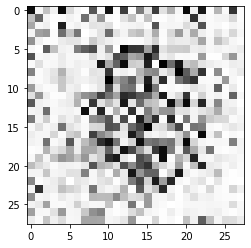

Currently on Epoch 2 of 300 total...acc=0.9899999499320984
Currently on Epoch 3 of 300 total...acc=0.9899999499320984
Currently on Epoch 4 of 300 total...acc=1.0
Currently on Epoch 5 of 300 total...acc=0.9950000047683716
Currently on Epoch 6 of 300 total...acc=0.9899999499320984


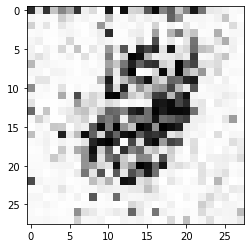

Currently on Epoch 7 of 300 total...acc=1.0
Currently on Epoch 8 of 300 total...acc=1.0
Currently on Epoch 9 of 300 total...acc=0.9749999642372131
Currently on Epoch 10 of 300 total...acc=0.9649999737739563
Currently on Epoch 11 of 300 total...acc=0.9350000023841858


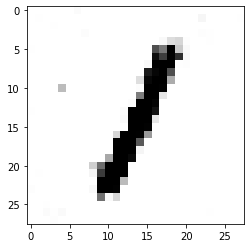

Currently on Epoch 12 of 300 total...acc=0.8999999761581421
Currently on Epoch 13 of 300 total...acc=0.9149999618530273
Currently on Epoch 14 of 300 total...acc=0.9449999928474426
Currently on Epoch 15 of 300 total...acc=0.9399999976158142
Currently on Epoch 16 of 300 total...acc=0.9549999833106995


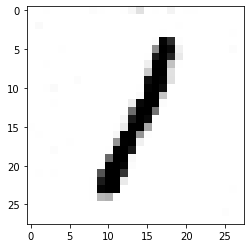

Currently on Epoch 17 of 300 total...acc=0.9399999976158142
Currently on Epoch 18 of 300 total...acc=0.9449999928474426
Currently on Epoch 19 of 300 total...acc=0.8849999904632568
Currently on Epoch 20 of 300 total...acc=0.949999988079071
Currently on Epoch 21 of 300 total...acc=0.9449999928474426


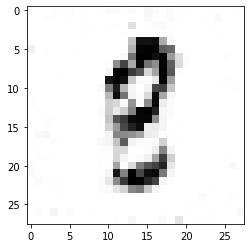

Currently on Epoch 22 of 300 total...acc=0.9699999690055847
Currently on Epoch 23 of 300 total...acc=0.9300000071525574
Currently on Epoch 24 of 300 total...acc=0.9300000071525574
Currently on Epoch 25 of 300 total...acc=0.9699999690055847
Currently on Epoch 26 of 300 total...acc=0.9449999928474426


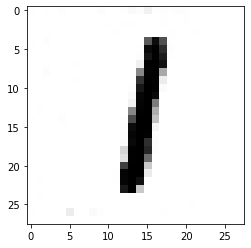

Currently on Epoch 27 of 300 total...acc=0.9549999833106995
Currently on Epoch 28 of 300 total...acc=0.9449999928474426
Currently on Epoch 29 of 300 total...acc=0.9649999737739563
Currently on Epoch 30 of 300 total...acc=0.9599999785423279
Currently on Epoch 31 of 300 total...acc=0.9549999833106995


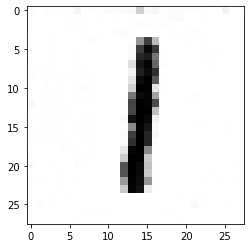

Currently on Epoch 32 of 300 total...acc=0.9549999833106995
Currently on Epoch 33 of 300 total...acc=0.949999988079071
Currently on Epoch 34 of 300 total...acc=0.9699999690055847
Currently on Epoch 35 of 300 total...acc=0.949999988079071
Currently on Epoch 36 of 300 total...acc=0.9649999737739563


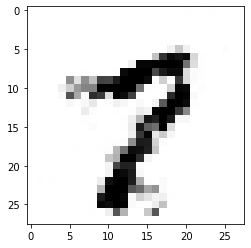

Currently on Epoch 37 of 300 total...acc=0.9649999737739563
Currently on Epoch 38 of 300 total...acc=0.9249999523162842
Currently on Epoch 39 of 300 total...acc=0.9699999690055847
Currently on Epoch 40 of 300 total...acc=0.9749999642372131
Currently on Epoch 41 of 300 total...acc=0.9899999499320984


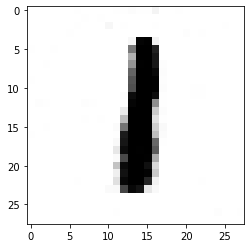

Currently on Epoch 42 of 300 total...acc=0.9749999642372131
Currently on Epoch 43 of 300 total...acc=0.9749999642372131
Currently on Epoch 44 of 300 total...acc=0.9649999737739563
Currently on Epoch 45 of 300 total...acc=0.9699999690055847
Currently on Epoch 46 of 300 total...acc=0.9699999690055847


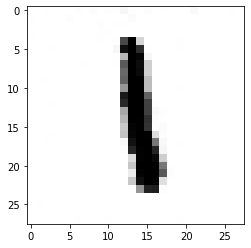

Currently on Epoch 47 of 300 total...acc=0.9699999690055847
Currently on Epoch 48 of 300 total...acc=0.9799999594688416
Currently on Epoch 49 of 300 total...acc=0.9749999642372131
Currently on Epoch 50 of 300 total...acc=0.9950000047683716
Currently on Epoch 51 of 300 total...acc=0.9899999499320984


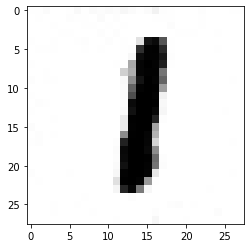

Currently on Epoch 52 of 300 total...acc=0.9899999499320984
Currently on Epoch 53 of 300 total...acc=1.0
Currently on Epoch 54 of 300 total...acc=0.98499995470047
Currently on Epoch 55 of 300 total...acc=0.9899999499320984
Currently on Epoch 56 of 300 total...acc=0.9399999976158142


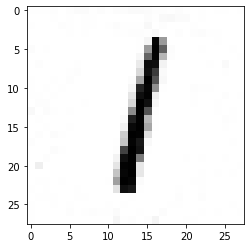

Currently on Epoch 57 of 300 total...acc=0.9549999833106995
Currently on Epoch 58 of 300 total...acc=0.9749999642372131
Currently on Epoch 59 of 300 total...acc=0.9649999737739563
Currently on Epoch 60 of 300 total...acc=0.9799999594688416
Currently on Epoch 61 of 300 total...acc=0.9699999690055847


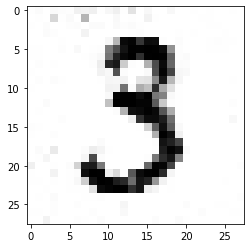

Currently on Epoch 62 of 300 total...acc=0.98499995470047
Currently on Epoch 63 of 300 total...acc=0.9749999642372131
Currently on Epoch 64 of 300 total...acc=0.9799999594688416
Currently on Epoch 65 of 300 total...acc=0.9649999737739563
Currently on Epoch 66 of 300 total...acc=0.9549999833106995


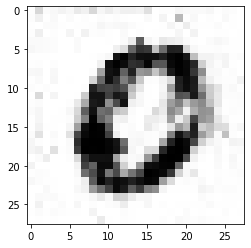

Currently on Epoch 67 of 300 total...acc=0.9449999928474426
Currently on Epoch 68 of 300 total...acc=0.9649999737739563
Currently on Epoch 69 of 300 total...acc=0.9599999785423279
Currently on Epoch 70 of 300 total...acc=0.9649999737739563
Currently on Epoch 71 of 300 total...acc=0.9799999594688416


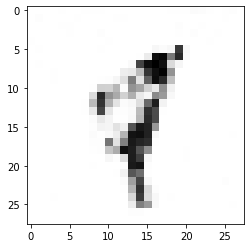

Currently on Epoch 72 of 300 total...acc=0.9699999690055847
Currently on Epoch 73 of 300 total...acc=0.9549999833106995
Currently on Epoch 74 of 300 total...acc=0.9649999737739563
Currently on Epoch 75 of 300 total...acc=0.9599999785423279
Currently on Epoch 76 of 300 total...acc=0.9649999737739563


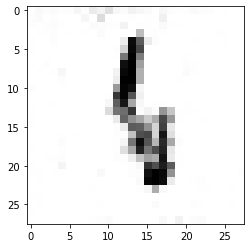

Currently on Epoch 77 of 300 total...acc=0.9749999642372131
Currently on Epoch 78 of 300 total...acc=0.9599999785423279
Currently on Epoch 79 of 300 total...acc=0.9749999642372131
Currently on Epoch 80 of 300 total...acc=0.9649999737739563
Currently on Epoch 81 of 300 total...acc=0.9799999594688416


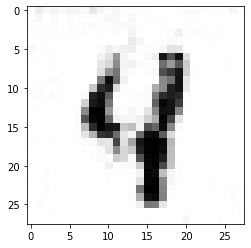

Currently on Epoch 82 of 300 total...acc=0.9699999690055847
Currently on Epoch 83 of 300 total...acc=0.9699999690055847
Currently on Epoch 84 of 300 total...acc=0.9549999833106995
Currently on Epoch 85 of 300 total...acc=0.9749999642372131
Currently on Epoch 86 of 300 total...acc=0.9899999499320984


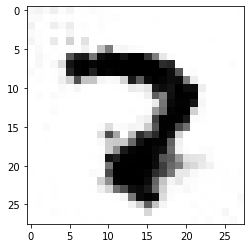

Currently on Epoch 87 of 300 total...acc=0.9649999737739563
Currently on Epoch 88 of 300 total...acc=0.98499995470047
Currently on Epoch 89 of 300 total...acc=0.949999988079071
Currently on Epoch 90 of 300 total...acc=0.9749999642372131
Currently on Epoch 91 of 300 total...acc=0.9749999642372131


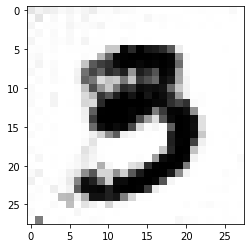

Currently on Epoch 92 of 300 total...acc=0.9699999690055847
Currently on Epoch 93 of 300 total...acc=0.9749999642372131
Currently on Epoch 94 of 300 total...acc=0.9549999833106995
Currently on Epoch 95 of 300 total...acc=0.98499995470047
Currently on Epoch 96 of 300 total...acc=0.9599999785423279


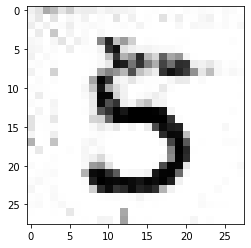

Currently on Epoch 97 of 300 total...acc=0.9699999690055847
Currently on Epoch 98 of 300 total...acc=0.9699999690055847
Currently on Epoch 99 of 300 total...acc=0.9549999833106995
Currently on Epoch 100 of 300 total...acc=0.9649999737739563
Currently on Epoch 101 of 300 total...acc=0.98499995470047


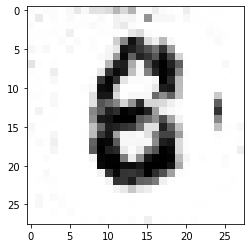

Currently on Epoch 102 of 300 total...acc=0.9699999690055847
Currently on Epoch 103 of 300 total...acc=0.9749999642372131
Currently on Epoch 104 of 300 total...acc=0.9799999594688416
Currently on Epoch 105 of 300 total...acc=1.0
Currently on Epoch 106 of 300 total...acc=0.9699999690055847


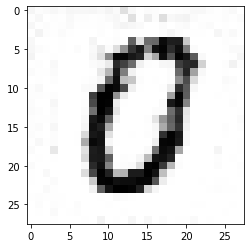

Currently on Epoch 107 of 300 total...acc=0.98499995470047
Currently on Epoch 108 of 300 total...acc=0.9799999594688416
Currently on Epoch 109 of 300 total...acc=1.0
Currently on Epoch 110 of 300 total...acc=0.98499995470047
Currently on Epoch 111 of 300 total...acc=0.9950000047683716


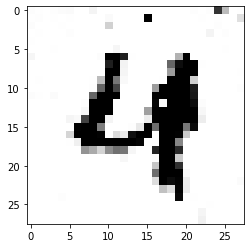

Currently on Epoch 112 of 300 total...acc=0.98499995470047
Currently on Epoch 113 of 300 total...acc=0.9899999499320984
Currently on Epoch 114 of 300 total...acc=0.9899999499320984
Currently on Epoch 115 of 300 total...acc=0.98499995470047
Currently on Epoch 116 of 300 total...acc=0.9749999642372131


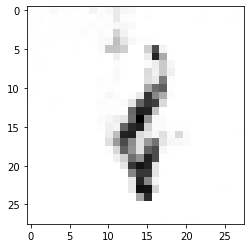

Currently on Epoch 117 of 300 total...acc=0.9649999737739563
Currently on Epoch 118 of 300 total...acc=0.9799999594688416
Currently on Epoch 119 of 300 total...acc=0.9749999642372131
Currently on Epoch 120 of 300 total...acc=0.98499995470047
Currently on Epoch 121 of 300 total...acc=0.98499995470047


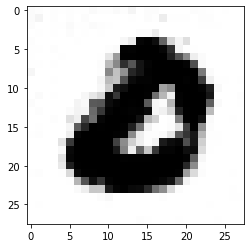

Currently on Epoch 122 of 300 total...acc=0.9749999642372131
Currently on Epoch 123 of 300 total...acc=0.9449999928474426
Currently on Epoch 124 of 300 total...acc=0.98499995470047
Currently on Epoch 125 of 300 total...acc=0.9749999642372131
Currently on Epoch 126 of 300 total...acc=0.98499995470047


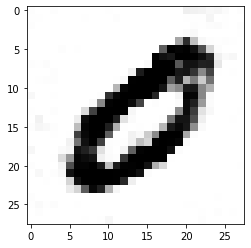

Currently on Epoch 127 of 300 total...acc=0.9599999785423279
Currently on Epoch 128 of 300 total...acc=0.9699999690055847
Currently on Epoch 129 of 300 total...acc=0.9950000047683716
Currently on Epoch 130 of 300 total...acc=1.0
Currently on Epoch 131 of 300 total...acc=0.9950000047683716


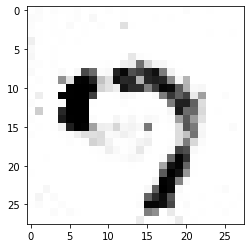

Currently on Epoch 132 of 300 total...acc=0.9749999642372131
Currently on Epoch 133 of 300 total...acc=0.9899999499320984
Currently on Epoch 134 of 300 total...acc=0.98499995470047
Currently on Epoch 135 of 300 total...acc=0.9799999594688416
Currently on Epoch 136 of 300 total...acc=0.98499995470047


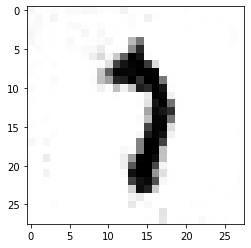

Currently on Epoch 137 of 300 total...acc=0.98499995470047
Currently on Epoch 138 of 300 total...acc=0.9899999499320984
Currently on Epoch 139 of 300 total...acc=0.9699999690055847
Currently on Epoch 140 of 300 total...acc=0.9950000047683716
Currently on Epoch 141 of 300 total...acc=0.9749999642372131


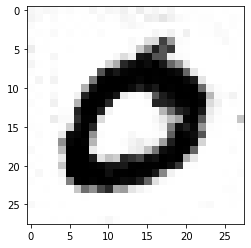

Currently on Epoch 142 of 300 total...acc=0.9799999594688416
Currently on Epoch 143 of 300 total...acc=0.9599999785423279
Currently on Epoch 144 of 300 total...acc=0.9950000047683716
Currently on Epoch 145 of 300 total...acc=0.9950000047683716
Currently on Epoch 146 of 300 total...acc=0.98499995470047


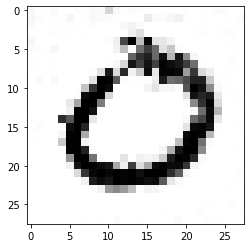

Currently on Epoch 147 of 300 total...acc=0.9749999642372131
Currently on Epoch 148 of 300 total...acc=0.9699999690055847
Currently on Epoch 149 of 300 total...acc=0.9950000047683716
Currently on Epoch 150 of 300 total...acc=0.9749999642372131
Currently on Epoch 151 of 300 total...acc=0.98499995470047


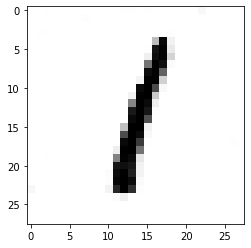

Currently on Epoch 152 of 300 total...acc=1.0
Currently on Epoch 153 of 300 total...acc=0.9699999690055847
Currently on Epoch 154 of 300 total...acc=0.949999988079071
Currently on Epoch 155 of 300 total...acc=0.9799999594688416
Currently on Epoch 156 of 300 total...acc=1.0


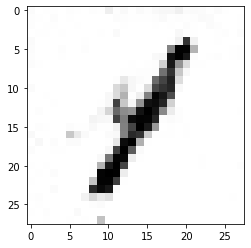

Currently on Epoch 157 of 300 total...acc=0.9799999594688416
Currently on Epoch 158 of 300 total...acc=0.98499995470047
Currently on Epoch 159 of 300 total...acc=0.9749999642372131
Currently on Epoch 160 of 300 total...acc=0.9799999594688416
Currently on Epoch 161 of 300 total...acc=0.9950000047683716


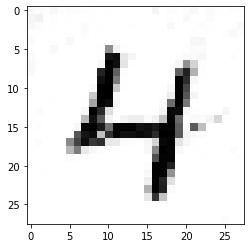

Currently on Epoch 162 of 300 total...acc=0.9799999594688416
Currently on Epoch 163 of 300 total...acc=0.9749999642372131
Currently on Epoch 164 of 300 total...acc=0.9899999499320984
Currently on Epoch 165 of 300 total...acc=0.9899999499320984
Currently on Epoch 166 of 300 total...acc=0.98499995470047


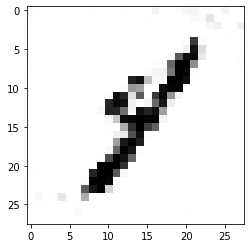

Currently on Epoch 167 of 300 total...acc=0.98499995470047
Currently on Epoch 168 of 300 total...acc=0.9950000047683716
Currently on Epoch 169 of 300 total...acc=0.9899999499320984
Currently on Epoch 170 of 300 total...acc=0.9950000047683716
Currently on Epoch 171 of 300 total...acc=1.0


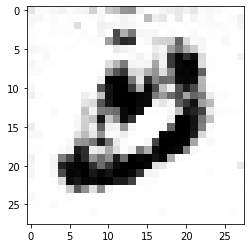

Currently on Epoch 172 of 300 total...acc=0.9899999499320984
Currently on Epoch 173 of 300 total...acc=0.9950000047683716
Currently on Epoch 174 of 300 total...acc=0.9799999594688416
Currently on Epoch 175 of 300 total...acc=0.98499995470047
Currently on Epoch 176 of 300 total...acc=0.9899999499320984


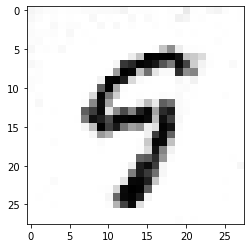

Currently on Epoch 177 of 300 total...acc=0.9899999499320984
Currently on Epoch 178 of 300 total...acc=0.9950000047683716
Currently on Epoch 179 of 300 total...acc=0.9950000047683716
Currently on Epoch 180 of 300 total...acc=0.98499995470047
Currently on Epoch 181 of 300 total...acc=0.9799999594688416


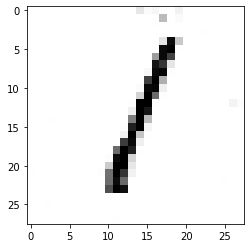

Currently on Epoch 182 of 300 total...acc=0.98499995470047
Currently on Epoch 183 of 300 total...acc=0.98499995470047
Currently on Epoch 184 of 300 total...acc=1.0
Currently on Epoch 185 of 300 total...acc=0.9899999499320984
Currently on Epoch 186 of 300 total...acc=0.9899999499320984


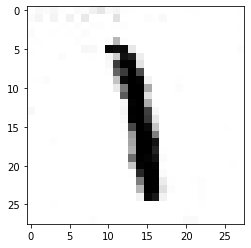

Currently on Epoch 187 of 300 total...acc=1.0
Currently on Epoch 188 of 300 total...acc=0.98499995470047
Currently on Epoch 189 of 300 total...acc=0.9899999499320984
Currently on Epoch 190 of 300 total...acc=0.9950000047683716
Currently on Epoch 191 of 300 total...acc=0.98499995470047


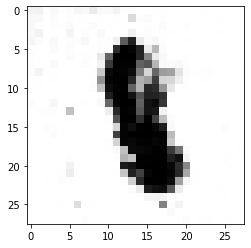

Currently on Epoch 192 of 300 total...acc=0.98499995470047
Currently on Epoch 193 of 300 total...acc=0.9950000047683716
Currently on Epoch 194 of 300 total...acc=0.9950000047683716
Currently on Epoch 195 of 300 total...acc=1.0
Currently on Epoch 196 of 300 total...acc=0.98499995470047


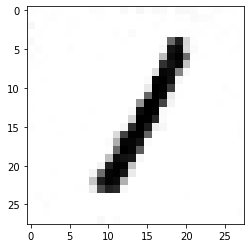

Currently on Epoch 197 of 300 total...acc=0.9799999594688416
Currently on Epoch 198 of 300 total...acc=0.98499995470047
Currently on Epoch 199 of 300 total...acc=0.9899999499320984
Currently on Epoch 200 of 300 total...acc=0.9899999499320984
Currently on Epoch 201 of 300 total...acc=0.9950000047683716


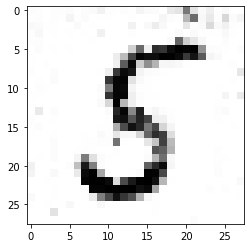

Currently on Epoch 202 of 300 total...acc=0.9950000047683716
Currently on Epoch 203 of 300 total...acc=0.9799999594688416
Currently on Epoch 204 of 300 total...acc=0.9749999642372131
Currently on Epoch 205 of 300 total...acc=0.9899999499320984
Currently on Epoch 206 of 300 total...acc=0.9950000047683716


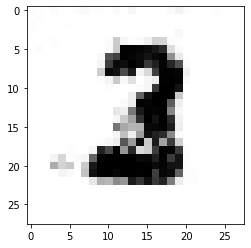

Currently on Epoch 207 of 300 total...acc=0.98499995470047
Currently on Epoch 208 of 300 total...acc=0.9950000047683716
Currently on Epoch 209 of 300 total...acc=0.9899999499320984
Currently on Epoch 210 of 300 total...acc=0.9899999499320984
Currently on Epoch 211 of 300 total...acc=0.9899999499320984


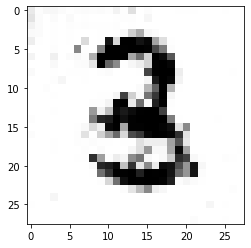

Currently on Epoch 212 of 300 total...acc=0.9899999499320984
Currently on Epoch 213 of 300 total...acc=0.9899999499320984
Currently on Epoch 214 of 300 total...acc=0.9950000047683716
Currently on Epoch 215 of 300 total...acc=1.0
Currently on Epoch 216 of 300 total...acc=0.98499995470047


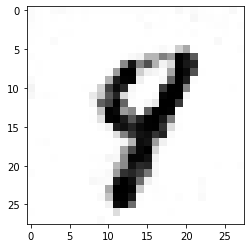

Currently on Epoch 217 of 300 total...acc=0.9899999499320984
Currently on Epoch 218 of 300 total...acc=0.98499995470047
Currently on Epoch 219 of 300 total...acc=0.9899999499320984
Currently on Epoch 220 of 300 total...acc=0.9950000047683716
Currently on Epoch 221 of 300 total...acc=0.9749999642372131


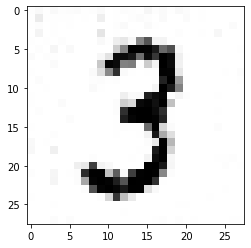

Currently on Epoch 222 of 300 total...acc=0.9749999642372131
Currently on Epoch 223 of 300 total...acc=0.9899999499320984
Currently on Epoch 224 of 300 total...acc=0.9950000047683716
Currently on Epoch 225 of 300 total...acc=0.9950000047683716
Currently on Epoch 226 of 300 total...acc=0.9899999499320984


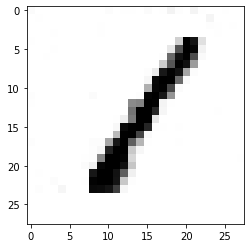

Currently on Epoch 227 of 300 total...acc=0.9899999499320984
Currently on Epoch 228 of 300 total...acc=0.9950000047683716
Currently on Epoch 229 of 300 total...acc=0.9899999499320984
Currently on Epoch 230 of 300 total...acc=0.9950000047683716
Currently on Epoch 231 of 300 total...acc=1.0


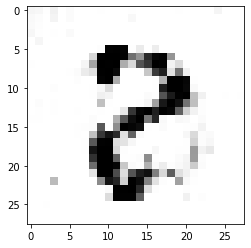

Currently on Epoch 232 of 300 total...acc=0.9950000047683716
Currently on Epoch 233 of 300 total...acc=1.0
Currently on Epoch 234 of 300 total...acc=0.9950000047683716
Currently on Epoch 235 of 300 total...acc=0.9950000047683716
Currently on Epoch 236 of 300 total...acc=0.9950000047683716


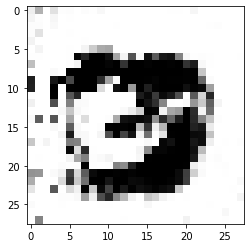

Currently on Epoch 237 of 300 total...acc=0.9749999642372131
Currently on Epoch 238 of 300 total...acc=0.9799999594688416
Currently on Epoch 239 of 300 total...acc=0.9799999594688416
Currently on Epoch 240 of 300 total...acc=0.9899999499320984
Currently on Epoch 241 of 300 total...acc=0.9799999594688416


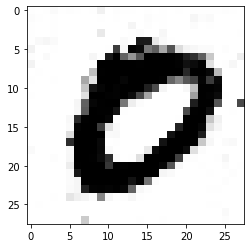

Currently on Epoch 242 of 300 total...acc=0.9799999594688416
Currently on Epoch 243 of 300 total...acc=0.9699999690055847
Currently on Epoch 244 of 300 total...acc=0.9799999594688416
Currently on Epoch 245 of 300 total...acc=0.9799999594688416
Currently on Epoch 246 of 300 total...acc=0.9899999499320984


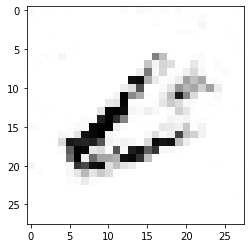

Currently on Epoch 247 of 300 total...acc=0.9749999642372131
Currently on Epoch 248 of 300 total...acc=0.9950000047683716
Currently on Epoch 249 of 300 total...acc=0.98499995470047
Currently on Epoch 250 of 300 total...acc=0.9699999690055847
Currently on Epoch 251 of 300 total...acc=0.9899999499320984


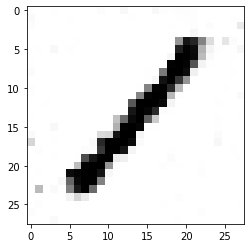

Currently on Epoch 252 of 300 total...acc=0.9749999642372131
Currently on Epoch 253 of 300 total...acc=0.9649999737739563
Currently on Epoch 254 of 300 total...acc=0.9799999594688416
Currently on Epoch 255 of 300 total...acc=0.98499995470047
Currently on Epoch 256 of 300 total...acc=0.9799999594688416


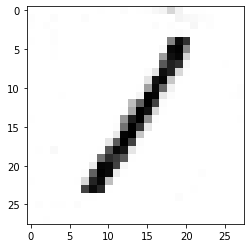

Currently on Epoch 257 of 300 total...acc=0.9599999785423279
Currently on Epoch 258 of 300 total...acc=0.9749999642372131
Currently on Epoch 259 of 300 total...acc=0.9899999499320984
Currently on Epoch 260 of 300 total...acc=0.9799999594688416
Currently on Epoch 261 of 300 total...acc=0.9899999499320984


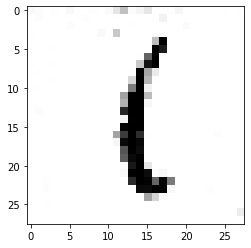

Currently on Epoch 262 of 300 total...acc=0.9899999499320984
Currently on Epoch 263 of 300 total...acc=1.0
Currently on Epoch 264 of 300 total...acc=1.0
Currently on Epoch 265 of 300 total...acc=0.9950000047683716
Currently on Epoch 266 of 300 total...acc=0.9899999499320984


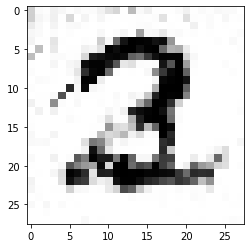

Currently on Epoch 267 of 300 total...acc=1.0
Currently on Epoch 268 of 300 total...acc=1.0
Currently on Epoch 269 of 300 total...acc=0.9950000047683716
Currently on Epoch 270 of 300 total...acc=0.98499995470047
Currently on Epoch 271 of 300 total...acc=1.0


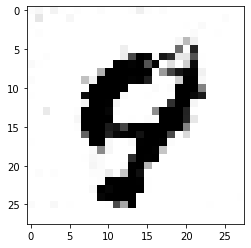

Currently on Epoch 272 of 300 total...acc=0.9950000047683716
Currently on Epoch 273 of 300 total...acc=1.0
Currently on Epoch 274 of 300 total...acc=0.9950000047683716
Currently on Epoch 275 of 300 total...acc=1.0
Currently on Epoch 276 of 300 total...acc=0.9899999499320984


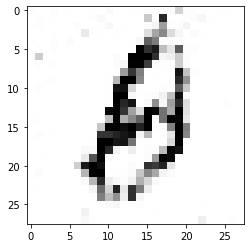

Currently on Epoch 277 of 300 total...acc=0.9950000047683716
Currently on Epoch 278 of 300 total...acc=0.9950000047683716
Currently on Epoch 279 of 300 total...acc=0.9950000047683716
Currently on Epoch 280 of 300 total...acc=1.0
Currently on Epoch 281 of 300 total...acc=1.0


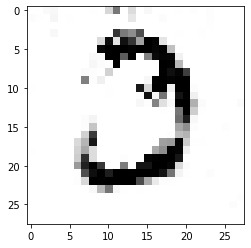

Currently on Epoch 282 of 300 total...acc=0.9950000047683716
Currently on Epoch 283 of 300 total...acc=0.9950000047683716
Currently on Epoch 284 of 300 total...acc=1.0
Currently on Epoch 285 of 300 total...acc=0.9950000047683716
Currently on Epoch 286 of 300 total...acc=0.9950000047683716


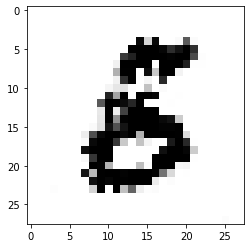

Currently on Epoch 287 of 300 total...acc=0.9899999499320984
Currently on Epoch 288 of 300 total...acc=1.0
Currently on Epoch 289 of 300 total...acc=1.0
Currently on Epoch 290 of 300 total...acc=1.0
Currently on Epoch 291 of 300 total...acc=0.9950000047683716


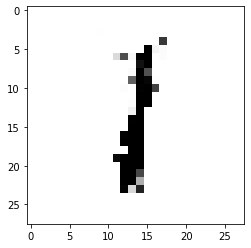

Currently on Epoch 292 of 300 total...acc=1.0
Currently on Epoch 293 of 300 total...acc=0.9950000047683716
Currently on Epoch 294 of 300 total...acc=1.0
Currently on Epoch 295 of 300 total...acc=1.0
Currently on Epoch 296 of 300 total...acc=0.9899999499320984


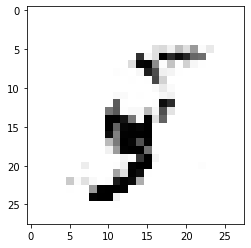

Currently on Epoch 297 of 300 total...acc=0.9899999499320984
Currently on Epoch 298 of 300 total...acc=0.9950000047683716
Currently on Epoch 299 of 300 total...acc=0.9950000047683716
Currently on Epoch 300 of 300 total...acc=1.0


In [24]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = len(Xej) // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = Xej[i*batch_size:(i+1)*batch_size]#mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch#.reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _,acc = sess.run([D_trainer,d_acc],feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
        
        #if e%10==0:
        print("Currently on Epoch {} of {} total...acc={}".format(e+1, epochs,acc))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(g_sizes,28,z,reuse=True),feed_dict={z: sample_z})
        if e%5==0:
            plt.imshow(gen_sample.reshape(28,28),cmap='Greys')
            plt.show()
        samples.append(gen_sample)
        
#        saver.save(sess, './models/500_epoch_model.ckpt')

In [ ]:
for j in range(50):
    if j%30==0:
        plt.imshow(samples[j].reshape(28,28),cmap='Greys')
        plt.show()

In [ ]:
7*7*128